In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import networkx as nx
from scipy import signal
import seaborn as sns
import pandas as pd
import re

# from functions.Connectivity import *
# from functions.Connectivity import calculate_and_plot_granger_causality
from scipy.signal import hilbert

from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq

In [3]:
main_path='/home/pablo/works/dev_thesis_SEEG/data/mainDatabase_patients/'
patient_name='sub-HUP146'
ref_data=1
# Document with file data
doc_file_data=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/'+patient_name+'_ses-presurgery_scans.tsv',sep='\t')

# Load the data

raw=mne.io.read_raw_edf(main_path+'/'+patient_name+'/'+'ses-presurgery/'+doc_file_data['filename'][ref_data],preload=True)
xyz_loc=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/ieeg/'+patient_name+'_ses-presurgery_acq-seeg_space-fsaverage_electrodes.tsv',sep='\t')
events=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/'+doc_file_data['filename'][ref_data].replace('_ieeg.edf','_events.tsv'),sep='\t')
channels=pd.read_csv(main_path+'/'+patient_name+'/'+'ses-presurgery/'+doc_file_data['filename'][ref_data].replace('_ieeg.edf','_channels.tsv'),sep='\t')


Extracting EDF parameters from /home/pablo/works/dev_thesis_SEEG/data/mainDatabase_patients/sub-HUP146/ses-presurgery/ieeg/sub-HUP146_ses-presurgery_task-ictal_acq-seeg_run-02_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 267263  =      0.000 ...   260.999 secs...


In [4]:
#Inside_network
good_channels=channels[channels['status']=='good']
inside_network=list(good_channels[(good_channels['status_description'] == 'resect') |
    (good_channels['status_description'] == 'soz') |
    (good_channels['status_description'] == 'resect,soz') |
    (good_channels['status_description'] == 'soz,resect')
]['name'])
good_channels=list(good_channels['name'])
xyz_loc=xyz_loc[['name','x','y','z']]
xyz_loc.columns = ['formatted_label','r','a','s']
#Select those who are good channels
xyz_loc=xyz_loc[xyz_loc['formatted_label'].isin(good_channels)].reset_index(drop=True)

In [5]:
crisis_center=float(events['onset'][0])  #Getting the first onset event
# Define the time window
tmin=crisis_center-30
tmax=crisis_center+30
raw_f=raw.copy().crop(tmin=tmin, tmax=tmax)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_543873/3383814097.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0,fmax=100)
/home/pablo/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


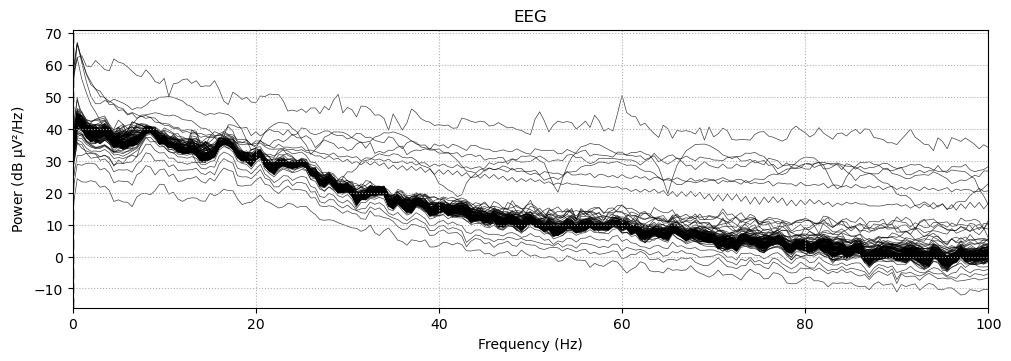

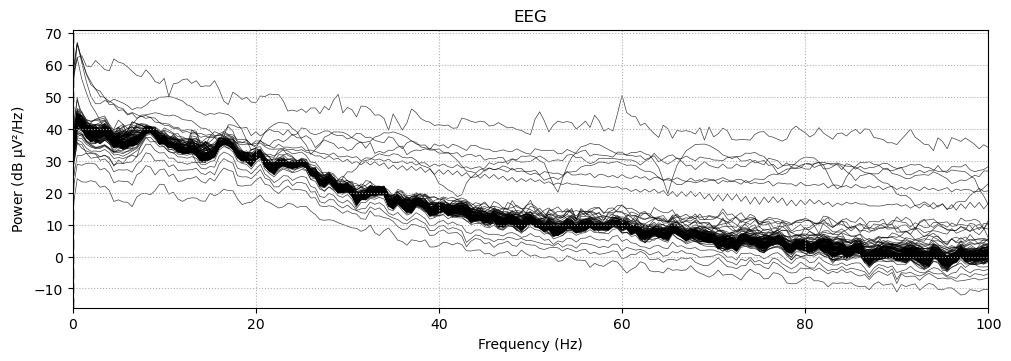

In [6]:
raw.plot_psd(fmin=0,fmax=100)

Opening raw data file /home/pablo/works/dev_thesis_SEEG/outputs/sub-HUP146/ref_1/percentile_0.9/sub-HUP146_filtered.fif...
Isotrak not found
    Range : 92160 ... 153600 =     90.000 ...   150.000 secs
Ready.
Reading 0 ... 61440  =      0.000 ...    60.000 secs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.000 (s)


/tmp/ipykernel_543873/2624649063.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/outputs/sub-HUP146/ref_1/percentile_0.9/sub-HUP146_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered=mne.io.read_raw_fif(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient_name}/ref_{ref_data}/percentile_0.9/{patient_name}_filtered.fif',preload=True)


Plotting power spectral density (dB=True).


/tmp/ipykernel_543873/2624649063.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filtered.drop_channels(['RI5','RG1','RG2','LG3']).plot_psd(fmin=0,fmax=100)
/home/pablo/miniconda3/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


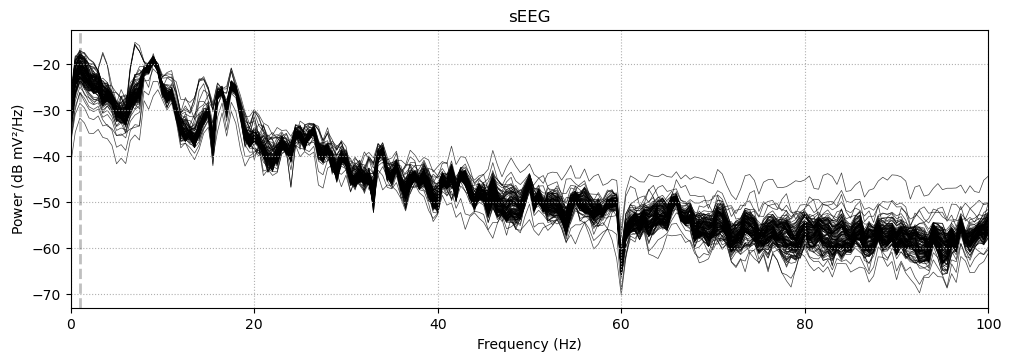

In [ ]:
raw_filtered=mne.io.read_raw_fif(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient_name}/ref_{ref_data}/percentile_0.9/{patient_name}_filtered.fif',preload=True)
# raw_filtered.drop_channels(['RI5','RG1','RG2','LG3']).plot_psd(fmin=0,fmax=100)

In [12]:
mne.io.read_raw_edf('/home/pablo/works/dev_thesis_SEEG/data/mainDatabase_patients/sub-HUP146/ses-presurgery/ieeg/sub-HUP146_ses-presurgery_task-ictal_acq-seeg_run-02_ieeg.edf',preload=True).plot()

Extracting EDF parameters from /home/pablo/works/dev_thesis_SEEG/data/mainDatabase_patients/sub-HUP146/ses-presurgery/ieeg/sub-HUP146_ses-presurgery_task-ictal_acq-seeg_run-02_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 267263  =      0.000 ...   260.999 secs...


In [8]:
raw_filtered.plot()

Using qt as 2D backend.


QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


In [16]:
# Channel Formating

#Find intersection of xyz_loc['formatted_label'] and epochs.ch_names
intersection = set(xyz_loc['formatted_label']).intersection(raw.ch_names)

# Filter the dataframe to keep only the intersecting labels
df_filtered = xyz_loc[xyz_loc['formatted_label'].isin(intersection)]

# Reorder the dataframe according to chnames (which will now only contain the intersecting labels)
df_filtered = df_filtered.set_index('formatted_label')

#Getting to know which inndexes from the original to eliminate 
cd=pd.Series(raw.ch_names).isin(intersection)
idx=cd.index[~cd].tolist()

#Eliminating the channels which are not in the intersection

channels_to_drop=[raw.ch_names[item] for item in idx]

raw.drop_channels(channels_to_drop)

xyz_loc = xyz_loc.set_index('formatted_label').reindex(raw.ch_names).reset_index()

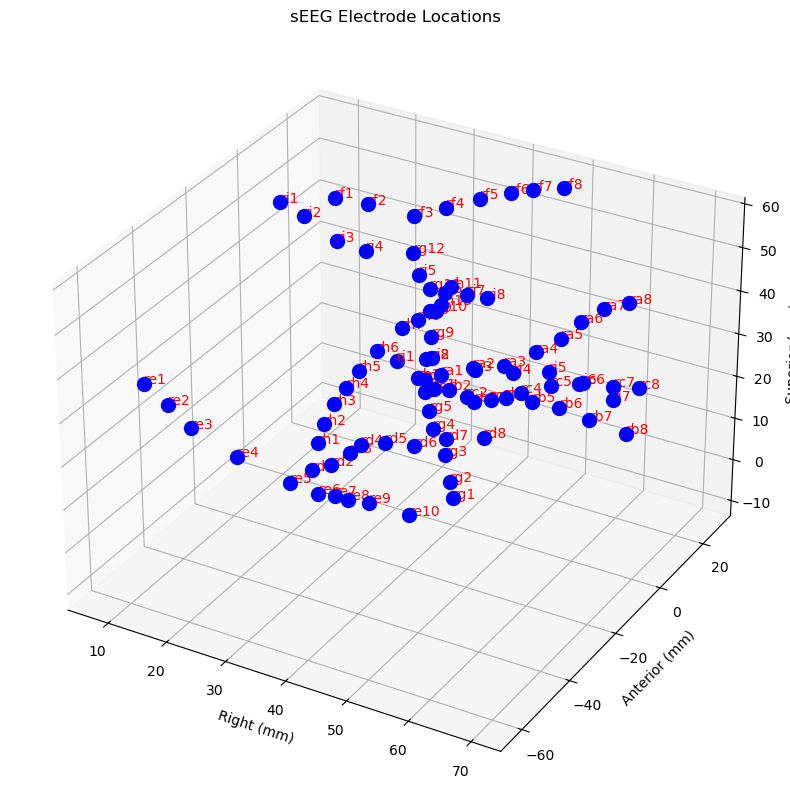

In [18]:
#Plot the electrodes ubications in a x,y,z 3D space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each electrode as a point
for i, row in xyz_loc.iterrows():
    ax.scatter(row['r'], row['a'], row['s'], color='b', s=100)

# Annotate each electrode with its name, without the "EEG" prefix and lowercase
for i, row in xyz_loc.iterrows():
    ax.text(row['r'], row['a'], row['s'], row['formatted_label'].lower(), color='r')
# Set labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

plt.show()

In [19]:
#####

mni2fsavg_file = "/home/pablo/works/dev_thesis_SEEG/New_data/Code/mni2fsaverage.npy"
mni2fsavg = np.load(mni2fsavg_file)
#Montage transformation 
# Prepare the dictionary for digitized montage
ch_pos = {}
xyz_loc_copy = xyz_loc.copy()
for _, row in xyz_loc.iterrows():
    # Original coordinates (in meters)
    original_point = np.array([row['r'], row['a'], row['s'], 1])  # Homogeneous
    
    # Transform the point
    transformed_point = mni2fsavg @ original_point
    transformed_point = transformed_point
    # Drop the homogeneous coordinate (last element)
    ch_pos[row['formatted_label']] = transformed_point[:3]
    #New coordinates
    xyz_loc_copy.loc[xyz_loc_copy['formatted_label'] == row['formatted_label'], ['r', 'a', 's']] = transformed_point[:3]


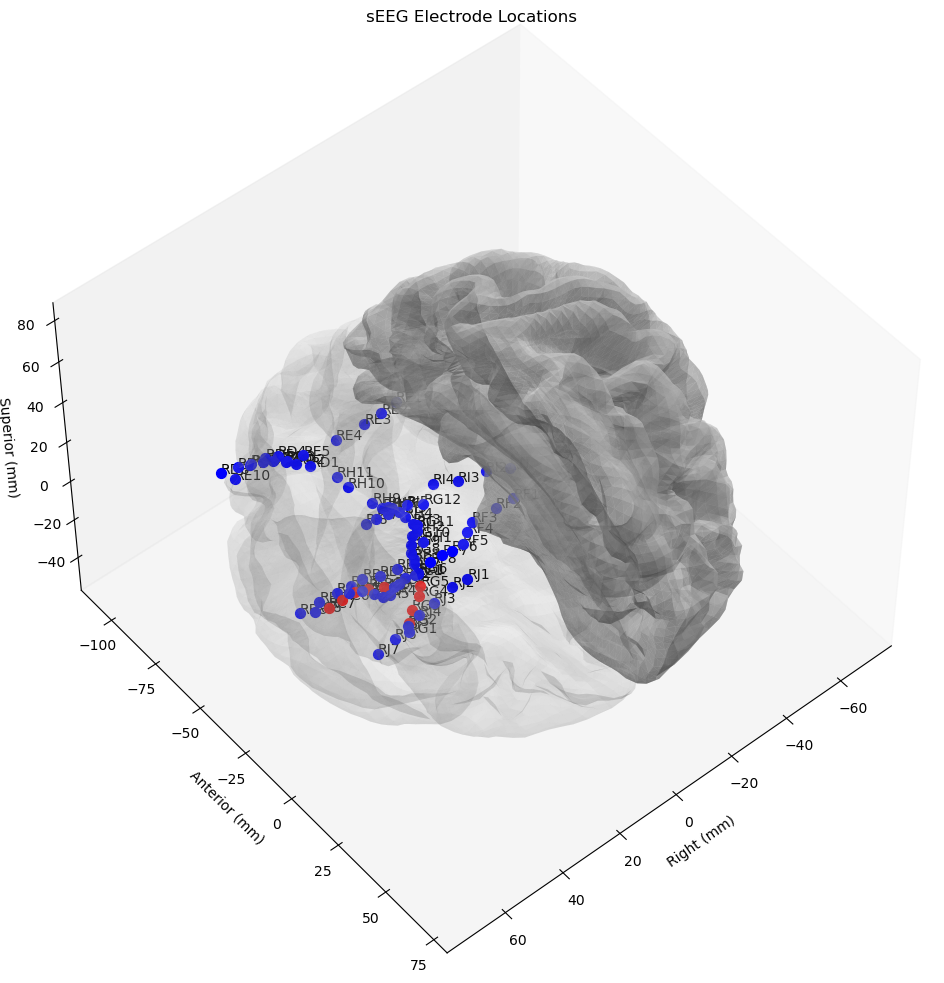

Electrode locations plotted


In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from nilearn import datasets
import pandas as pd


# Load fsaverage template (high-res pial surface)
fsaverage = datasets.fetch_surf_fsaverage()
left_mesh_file = fsaverage.pial_left  # Pial surface of the left hemisphere
right_mesh_file = fsaverage.pial_right  # Pial surface of the right hemisphere

# Load the meshes using nibabel
left_mesh = nib.load(left_mesh_file)
right_mesh = nib.load(right_mesh_file)

left_coords = left_mesh.darrays[0].data  # Coordinates
left_faces = left_mesh.darrays[1].data  # Faces (triangles)

right_coords = right_mesh.darrays[0].data
right_faces = right_mesh.darrays[1].data

# Create 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot left hemisphere
ax.plot_trisurf(left_coords[:, 0], left_coords[:, 1], left_coords[:, 2], 
                triangles=left_faces, color='lightgray', alpha=0.5)

# Plot right hemisphere
ax.plot_trisurf(right_coords[:, 0], right_coords[:, 1], right_coords[:, 2], 
                triangles=right_faces, color='lightgray', alpha=0.1)

# Plot electrodes
for i, row in xyz_loc_copy.iterrows():
    color = 'red' if row['formatted_label'] in inside_network else 'blue'
    ax.scatter(row['r'], row['a'], row['s'], color=color, s=50)
    ax.text(row['r'], row['a'], row['s'], row['formatted_label'], color='black')
    # ax.scatter(row['r'], row['a'], row['s'], color='blue', s=50)
    # ax.text(row['r'], row['a'], row['s'], row['formatted_label'], color='black')

# Set axis labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

# Adjust view and plot settings
ax.view_init(azim=50, elev=50)  # Rotate for better view
ax.grid(False)
plt.show()

print('Electrode locations plotted')

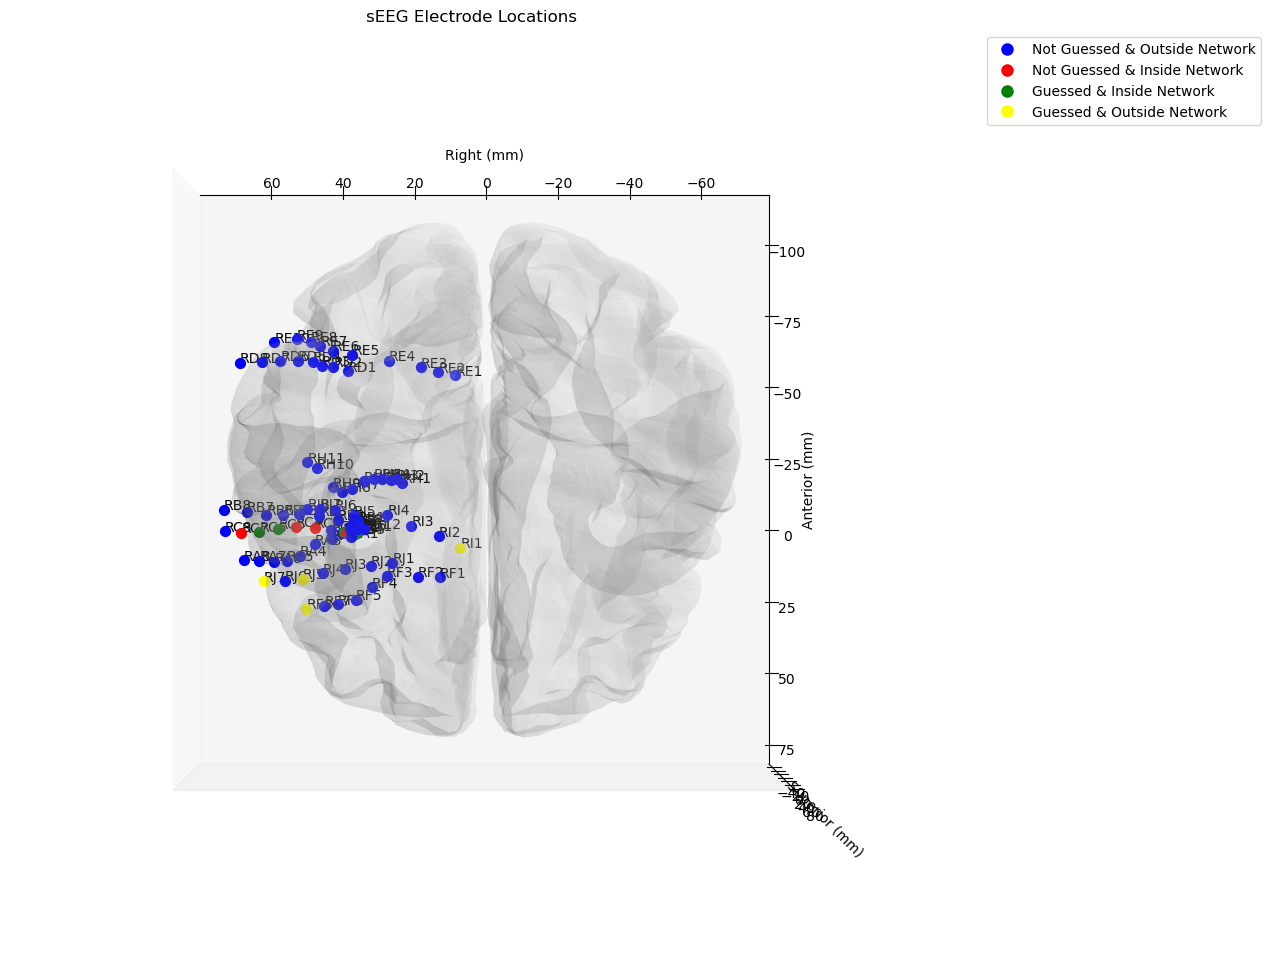

Electrode locations plotted


In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nibabel as nib
from nilearn import datasets
import pandas as pd

# Load fsaverage template (high-res pial surface)
fsaverage = datasets.fetch_surf_fsaverage()
left_mesh_file = fsaverage.pial_left  # Pial surface of the left hemisphere
right_mesh_file = fsaverage.pial_right  # Pial surface of the right hemisphere

# Load the meshes using nibabel
left_mesh = nib.load(left_mesh_file)
right_mesh = nib.load(right_mesh_file)

left_coords = left_mesh.darrays[0].data  # Coordinates
left_faces = left_mesh.darrays[1].data  # Faces (triangles)

right_coords = right_mesh.darrays[0].data
right_faces = right_mesh.darrays[1].data

### Reading guesses
guesses = pd.read_csv(f'/home/pablo/works/dev_thesis_SEEG/outputs/{patient_name}/ref_0/percentile_0.99/normalized_densities_high_gamma1_distance_.csv',
                      sep=',', index_col=0)
threshold = 0.6
channel_guesses = guesses[guesses > threshold].dropna().index.tolist()

# Create 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot left hemisphere
ax.plot_trisurf(left_coords[:, 0], left_coords[:, 1], left_coords[:, 2],
                triangles=left_faces, color='lightgray', alpha=0.1)

# Plot right hemisphere
ax.plot_trisurf(right_coords[:, 0], right_coords[:, 1], right_coords[:, 2],
                triangles=right_faces, color='lightgray', alpha=0.1)

# Plot electrodes
legend_elements = []  # For building the legend
plotted_labels = set()  # To avoid duplicate labels in the legend

for i, row in xyz_loc_copy.iterrows():
    label = row['formatted_label']
    
    # Determine color based on conditions
    if label in channel_guesses:
        color = 'green' if label in inside_network else 'yellow'
    else:
        color = 'red' if label in inside_network else 'blue'
    
    # Plot electrode and label
    ax.scatter(row['r'], row['a'], row['s'], color=color, s=50)
    ax.text(row['r'], row['a'], row['s'], label, color='black')
    
    # Add to legend if not already added
    if color not in plotted_labels:
        legend_label = (
            "Guessed & Inside Network" if color == 'green' else
            "Guessed & Outside Network" if color == 'yellow' else
            "Not Guessed & Inside Network" if color == 'red' else
            "Not Guessed & Outside Network"
        )
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                          markerfacecolor=color, markersize=10, label=legend_label))
        plotted_labels.add(color)

# Add legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

# Set axis labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

# Adjust view and plot settings
ax.view_init(azim=90, elev=90)  # Rotate for better view
ax.grid(False)
plt.show()

print('Electrode locations plotted')



### TVB Patients preparation

Creating RawArray with float64 data, n_channels=588, n_times=30769
    Range : 0 ... 30768 =      0.000 ...    60.094 secs
Ready.
Channel locations saved to 'channel_locations.csv'.


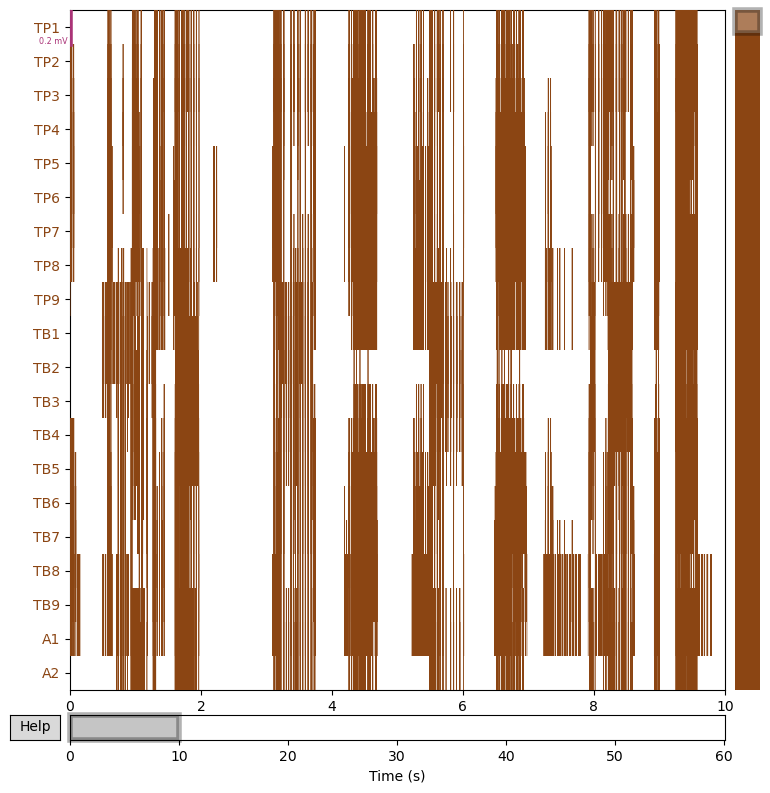

Writing /home/pablo/works/dev_thesis_SEEG/Pipeline/S5_x2x1.fif


/tmp/ipykernel_219045/4239214758.py:48: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/Pipeline/S5_x2x1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save("S5_x2x1.fif", overwrite=True)


Closing /home/pablo/works/dev_thesis_SEEG/Pipeline/S5_x2x1.fif
[done]


In [10]:
import h5py
import numpy as np
import pandas as pd
import mne

# Paths to the files
file_path = '/home/pablo/works/dev_thesis_SEEG/data/TVB_patients/S5/TimeSeriesSEEG_172f99c1c86d4e3d8c1d9414ba86e0f1.h5'
file_path2 = '/home/pablo/works/dev_thesis_SEEG/data/TVB_patients/S5/Sensors_568ffb7358f84a0eb4e9ea3ff9a4568b.h5'

# Step 1: Load time-series data
with h5py.File(file_path, 'r') as h5_file:
    # Extract data and time
    data = h5_file['data'][:]  # Shape: (samples, variables, contacts, format)
    time = h5_file['time'][:]  # Shape: (samples,)

# Select one variable (e.g., first variable)
variable_index = 4
selected_data = data[:, variable_index, :, 0]  # Shape: (samples, contacts)

# Step 2: Load channel names and locations
with h5py.File(file_path2, 'r') as h5_file:
    # Assuming channel names and locations are stored in the file
    channel_names = h5_file['labels'][:].astype(str)  # Channel names
    locations = h5_file['locations'][:]  # Shape: (contacts, 3)

# Convert locations to a Pandas DataFrame
xyz_loc = pd.DataFrame(locations, columns=['r', 'a', 's'], index=channel_names)
xyz_loc.index.name = 'Channel'

# Step 3: Prepare MNE RawArray
sfreq = 512  # Replace with actual sampling frequency (Hz)
channel_types = ['seeg'] * len(channel_names)  # SEEG channel type

# Create MNE info structure
info = mne.create_info(ch_names=channel_names.tolist(), sfreq=sfreq, ch_types=channel_types)

# Create RawArray
raw = mne.io.RawArray(selected_data.T, info)  # Transpose to (n_channels, n_times)

# Step 4: Save channel locations to a CSV and visualize MNE data
# xyz_loc.to_csv('channel_locations.csv')  # Save locations to a file
print("Channel locations saved to 'channel_locations.csv'.")

# Visualize the data
raw.plot()

# Optional: Save the MNE Raw object
raw.save("S5_x2x1.fif", overwrite=True)


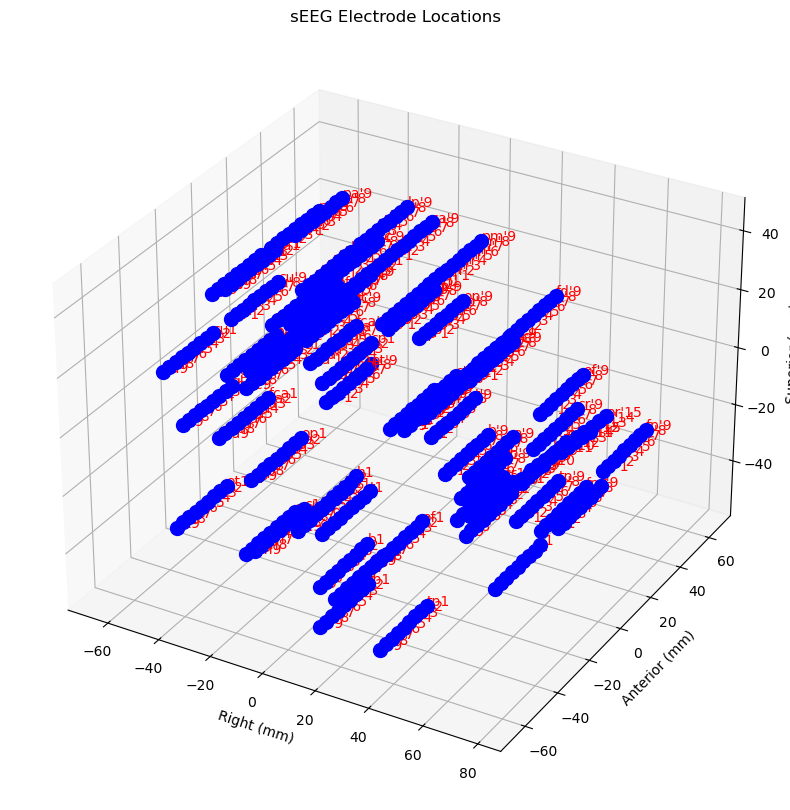

In [12]:
#Plot the electrodes ubications in a x,y,z 3D space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each electrode as a point
for i, row in xyz_loc.iterrows():
    ax.scatter(row['r'], row['a'], row['s'], color='b', s=100)

# Annotate each electrode with its name, without the "EEG" prefix and lowercase
for i, row in xyz_loc.iterrows():
    ax.text(row['r'], row['a'], row['s'], row.name.lower(), color='r')
# Set labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

plt.show()

In [2]:
#Save xyz_loc to a csv file
xyz_loc.to_csv('channel_locations.csv')  # Save locations to a file